In [1]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from matplotlib import pyplot as plt
from homography import apply_homography
from scipy.spatial import distance as dist

In [2]:
model = YOLO("../model/chessboard_segmentation.pt")

# Read Image

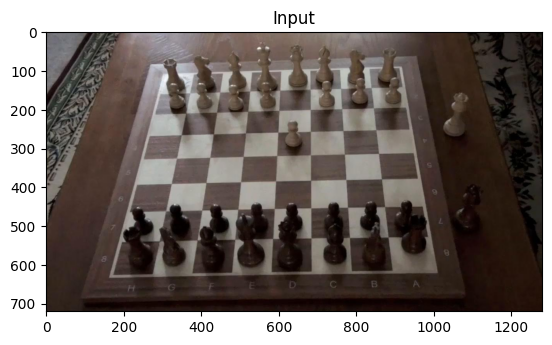

In [3]:
img = cv2.imread("../images/895_png_jpg.rf.bc5d19941773e11506e030d6299742ca.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Input')
plt.show()

# Make Model make Predictions

In [4]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
results = model.predict(img, conf=0.9, save=False)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


0: 384x640 1 chessboard, 85.3ms
Speed: 4.3ms preprocess, 85.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


# Create Mask, Contour from Mask and apply Contour Approximation on Contour

<Figure size 640x480 with 0 Axes>

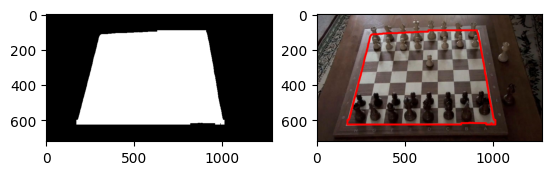

In [5]:
contour = None
img2 = img.copy()

for result in results:
    for index, item in enumerate(result):
        # create mask
        binary_mask = np.zeros(img.shape[:2], np.uint8)
        contour_pred = item.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
        new_img = cv2.drawContours(binary_mask, [contour_pred], -1, (255, 255, 255), cv2.FILLED)

        # create contour from mask
        contour_from_mask, hierarchy = cv2.findContours(new_img, 1, 2)
        cv2.drawContours(img2, contour_from_mask, -1, (255, 0, 0), 10)

        # reduce the points of the contour
        for cnt in contour_from_mask:
            epsilon = 0.01 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)

        plt.figure()
        figure, axis = plt.subplots(1, 2)
        axis[0].imshow(new_img, cmap="gray")
        axis[1].imshow(img2, cmap="gray")

        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

        cv2.imwrite('yoloseg/2.jpg', new_img)
        cv2.imwrite('yoloseg/3.jpg', img2)

        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        cv2.circle(img2, (int(approx[0][0][0]), int(approx[0][0][1])), 80, (0, 0, 255), -1)
        cv2.circle(img2, (int(approx[1][0][0]), int(approx[1][0][1])), 80, (0, 0, 255), -1)
        cv2.circle(img2, (int(approx[2][0][0]), int(approx[2][0][1])), 80, (0, 0, 255), -1)
        cv2.circle(img2, (int(approx[3][0][0]), int(approx[3][0][1])), 80, (0, 0, 255), -1)

        # axis[2].imshow(img2, cmap="gray")

        img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

        cv2.imwrite('yoloseg/4.jpg', img2)


# Sort Points

In [6]:
# Get points from contour
pts_1 = np.array(approx, dtype=np.float32).reshape(-1, 2)

print(pts_1)
xSorted = pts_1[np.argsort(pts_1[:, 0]), :]
print(xSorted)

leftMost = xSorted[:2, :]
rightMost = xSorted[2:, :]
    
leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
(top_left, bottom_left) = leftMost
 
D = dist.cdist(top_left[np.newaxis], rightMost, "euclidean")[0]
(bottom_right, top_right) = rightMost[np.argsort(D)[::-1], :]

[[        906          92]
 [        310         116]
 [        172         626]
 [       1010         626]]
[[        172         626]
 [        310         116]
 [        906          92]
 [       1010         626]]


# Apply Homography

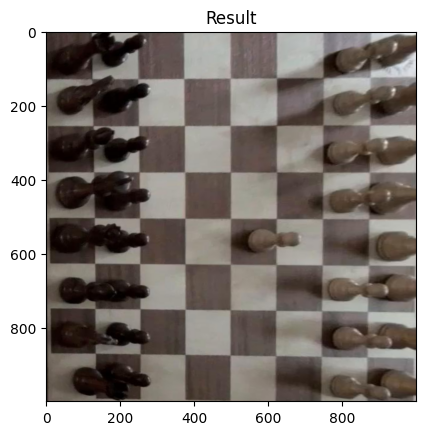

In [7]:
pts_1 = np.array([
    bottom_left,
    top_left,
    bottom_right,
    top_right,
], dtype=np.float32)

height, width, _ = img.shape
img_size = (height+width)//2
pts_2 = np.float32([[0, 0], [img_size, 0], [0, img_size], [img_size, img_size]])

# calculate matrix based on mapping pts_1 to pts_2
M = cv2.getPerspectiveTransform(pts_1, pts_2)

# apply homography
dst = cv2.warpPerspective(img, M, (img_size, img_size))

plt.imshow(dst, cmap='gray')
plt.title('Result')
plt.show()